In [9]:
import tensorflow as tf
import numpy as np
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import f1_score


def get_fast_dataset(e2_npy, srs_npy, batch_size=4, e2_len=20, srs_input_rows=100, pred_offset=50):
    # Load the binary data
    e2_data = np.load(e2_npy)
    srs_data = np.load(srs_npy)

    # Calculate valid steps
    num_steps_srs = (len(srs_data) - (srs_input_rows + pred_offset)) // 50
    num_steps_e2 = len(e2_data) - e2_len
    num_steps = min(num_steps_e2, num_steps_srs)

    def data_generator():
        for t in range(num_steps):
            # E2 Processing
            e2_chunk = e2_data[t : t + e2_len]
            # Fast flatten and reshape
            X_e2 = np.zeros(380, dtype=np.float32)
            X_e2[:e2_chunk.size] = e2_chunk.flatten()[:380]
            X_e2 = X_e2.reshape(5, 4, 19)

            # SRS Processing (Jumping by 50)
            srs_start = t * 50
            X_srs = srs_data[srs_start : srs_start + srs_input_rows].reshape(20, 20, 1536)

            # Label
            y = srs_data[srs_start + srs_input_rows + pred_offset - 1]
            
            yield (X_e2, X_srs), y

    output_signature = (
        (tf.TensorSpec(shape=(5, 4, 19), dtype=tf.float32), 
         tf.TensorSpec(shape=(20, 20, 1536), dtype=tf.float32)),
        tf.TensorSpec(shape=(4, 1536), dtype=tf.float32)
    )

    ds = tf.data.Dataset.from_generator(data_generator, output_signature=output_signature)

    return ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)



In [10]:
def create_model(e2_input_shape=(5, 4, 19), srs_input_shape=(20, 20, 1536), lstm_units=128, dropout_rate=0.3):
    # Radio Branch
    radio_input = layers.Input(shape=e2_input_shape, name='radio_input')
    r1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(radio_input)
    r1 = layers.BatchNormalization()(r1)
    r1 = layers.ZeroPadding2D(padding=((0,0),(0,1)))(r1) # Result: (5, 5, 32)

    # SRS Branch
    srs_input = layers.Input(shape=srs_input_shape, name='srs_input')
    s1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(srs_input) # Reduced filters for speed
    s1 = layers.MaxPooling2D((2, 2))(s1) # 10x10
    s1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(s1)
    s1 = layers.MaxPooling2D((2, 2))(s1) # 5x5
    s1 = layers.BatchNormalization()(s1)

    # Concatenate
    x = layers.Concatenate(axis=-1)([r1, s1]) # (5, 5, 32 + 64)
    x = layers.Reshape((25, 96))(x)
    x = layers.LSTM(lstm_units, return_sequences=True)(x)
    x = layers.Flatten()(x) 
    x = layers.Dense(4 * 1536)(x)
    output = layers.Reshape((4, 1536))(x)

    model = models.Model(inputs=[radio_input, srs_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

In [11]:
model = create_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 srs_input (InputLayer)         [(None, 20, 20, 153  0           []                               
                                6)]                                                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 20, 20, 128)  1769600     ['srs_input[0][0]']              
                                                                                                  
 radio_input (InputLayer)       [(None, 5, 4, 19)]   0           []                               
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 10, 10, 128)  0          ['conv2d_7[0][0]']         

Epoch 1/30
47/47 [==============================] - 2s 28ms/step - loss: 3971.3792
Epoch 2/30
47/47 [==============================] - 1s 27ms/step - loss: 4051.7456
Epoch 3/30
47/47 [==============================] - 1s 26ms/step - loss: 3842.6028
Epoch 4/30
47/47 [==============================] - 1s 26ms/step - loss: 3674.6873
Epoch 5/30
47/47 [==============================] - 1s 26ms/step - loss: 3565.0930
Epoch 6/30
47/47 [==============================] - 1s 26ms/step - loss: 3444.9128
Epoch 7/30
47/47 [==============================] - 1s 26ms/step - loss: 3342.7041
Epoch 8/30
47/47 [==============================] - 1s 26ms/step - loss: 3292.4460
Epoch 9/30
47/47 [==============================] - 1s 27ms/step - loss: 3246.8835
Epoch 10/30
47/47 [==============================] - 1s 26ms/step - loss: 3162.6208
Epoch 11/30
47/47 [==============================] - 1s 25ms/step - loss: 3071.4492
Epoch 12/30
47/47 [==============================] - 1s 26ms/step - loss: 2986.1372
E

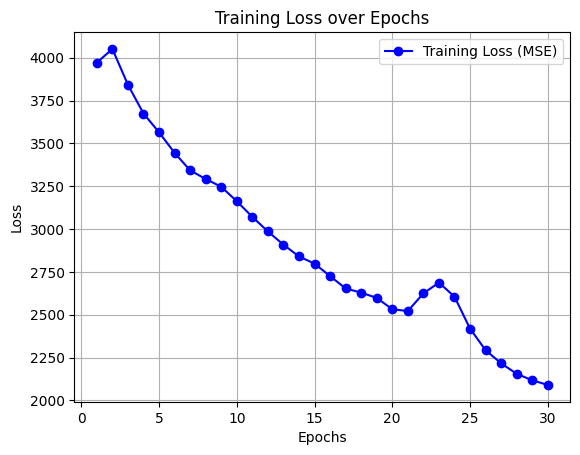

In [14]:
train_ds = get_fast_dataset("train_e2.npy", "train_srs.npy", batch_size=8) # Increased batch size

history = model.fit(train_ds, epochs=30)

loss = history.history['loss']
epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'bo-', label='Training Loss (MSE)')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show() 

In [13]:
test_e2_npy, test_srs_npy = ("P:/SP Challenge/Model/train_e2.npy", "P:/SP Challenge/Model/train_srs.npy")


test_ds = get_fast_dataset(test_e2_npy, test_srs_npy)


test_loss = model.evaluate(test_ds)


y_true_list = []
for _, y in test_ds:
    y_true_list.append(y.numpy())

y_true = np.concatenate(y_true_list, axis=0) 

print("Generating predictions...")
predictions = model.predict(test_ds) 

THRESHOLD = 0.5 

y_true_binary = (y_true > THRESHOLD).astype(int).flatten()
y_pred_binary = (predictions > THRESHOLD).astype(int).flatten()


f1 = f1_score(y_true_binary, y_pred_binary)

print(f"--- Results ---")
print(f"Test MSE: {test_loss}")
print(f"F1 Score (at threshold {THRESHOLD}): {f1}")

93/93 [==============================] - 1s 10ms/step - loss: 4203.6201
Generating predictions...
93/93 [==============================] - 1s 9ms/step
--- Results ---
Test MSE: 4203.6201171875
F1 Score (at threshold 0.5): 0.4850963673728505
